# Parent Document Retriever

which issue this parent-child retrieval will solve.

You may want to have small documents, so that their embeddings can most accurately reflect their meaning. If too long, then the embeddings can lose meaning.

You want to have long enough documents that the context of each chunk is retained.

The ParentDocumentRetriever strikes that balance by splitting and storing small chunks of data. During retrieval, it first fetches the small chunks but then looks up the parent ids for those chunks and returns those larger documents.

Note that "parent document" refers to the document that a small chunk originated from. This can either be the whole raw document OR a larger chunk.

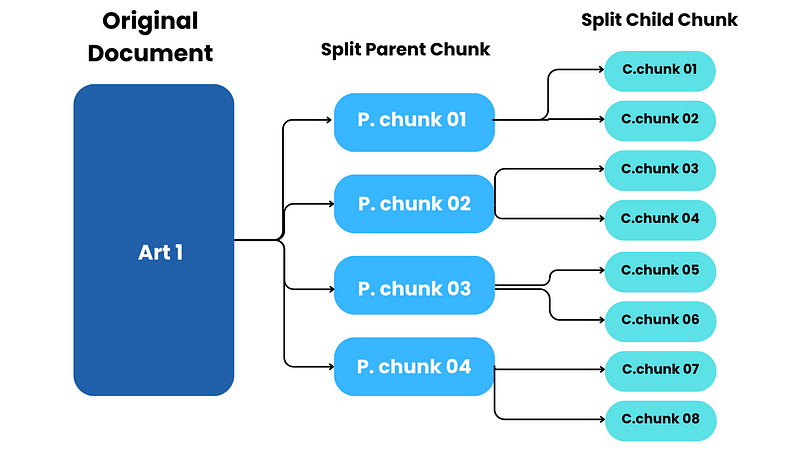

**Dataset size:**  Larger datasets generally benefit from more powerful models like MPNet.

**Computational resources:**  If you have limited resources, BGE Small En or MiniLM might be better options.

**Task complexity:**  For complex tasks like question answering or text summarization, MPNet is often preferred.

**Embedding dimensionality:**  Different models produce embeddings of varying dimensions.Choose based on downstream task requirements.

**Performance vs. efficiency trade-off:** Decide if you prioritize high accuracy or faster processing

#####Experimentation is key. Try different models and evaluate their performance on your specific task and dataset to find the best fit.

MTEB: Massive Text Embedding Benchmark

MPNET: Masked and Permuted Pre-training for Language Understanding.

BGE(BAAI general embedding)
BAAI: https://huggingface.co/BAAI

https://huggingface.co/sentence-transformers

https://huggingface.co/spaces/mteb/leaderboard

https://huggingface.co/blog/mteb

#### The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality.

In [1]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
import os
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

embeddings = OpenAIEmbeddings()
llm = ChatOpenAI(model="gpt-4o")

In [2]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma

loader = PyPDFLoader("state_of_union.pdf")
docs = loader.load()

child_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
child_docs = child_splitter.split_documents(docs)


vectorstore = Chroma(
    collection_name="full_documents", embedding_function=embeddings
)

store = InMemoryStore()

In [3]:
from langchain.retrievers import ParentDocumentRetriever
retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

retriever.add_documents(docs, ids=None)
list(store.yield_keys())

retrieved_docs= retriever.invoke("What does Biden say about defending democracy?")
print(retrieved_docs[0].page_content)

3/8/24, 6:43 PM Biden’s 2024 State of the Union Address: Read the Full Transcript - The New York Times
https://www.nytimes.com/2024/03/08/us/politics/state-of-the-union-transcript-biden.html 3/26
My message to President Putin, who I have known for a long time, is simple: We
will not walk away. We will not bow down. I will not bow down.
In a literal sense, history is watching. History is watching. Just like history
watched three years ago on Jan. 6, when insurrectionists stormed this very Capitol
and placed a dagger to the throat of American democracy.
Many of you were here on that darkest of days. We all saw with our own eyes. The
insurrectionists were not patriots. They had come to stop the peaceful transfer of
power, to overturn the will of the people.
Jan. 6 lies about the 2020 election, and the plots to steal the election, posed a great,
gravest threat to U.S. democracy since the Civil War.
But they failed. America stood. America stood strong and democracy prevailed.
We must be hon

In [4]:
print(len(retrieved_docs[0].page_content))

1851


In [5]:
# This text splitter is used to create the parent documents
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=1000)

store1 = InMemoryStore()

vectorstore1 = Chroma(
    collection_name="full_documents", embedding_function=embeddings
)

In [6]:
retriever2 = ParentDocumentRetriever(
    vectorstore=vectorstore1,
    docstore=store1,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter,
)

retriever2.add_documents(docs)
len(list(store1.yield_keys()))

74

In [7]:
len(list(store.yield_keys()))

26

In [8]:
retrieved_docs2= retriever2.invoke("What does Biden say about defending democracy?")
retrieved_docs2

[Document(metadata={'producer': 'Skia/PDF m122', 'creator': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36', 'creationdate': '2024-03-08T23:43:36+00:00', 'moddate': '2024-03-08T23:43:36+00:00', 'source': 'state_of_union.pdf', 'total_pages': 26, 'page': 24, 'page_label': '25'}, page_content='Whether young or old, I’ve always been known — I’ve always known what\nendures. I’ve known our North Star.\nThe very idea of America is that we are all created equal, deserves to be treated\nequally throughout our lives. We’ve never fully lived up to that idea, but we’ve\nnever walked away from it either.\nAnd I won’t walk away from it now. I’m optimistic. I really am, I’m optimistic,\nNancy.\nMy fellow Americans, the issue facing our nation isn’t how old we are, it’s how old\nare our ideas.\nHate, anger, revenge, retribution are the oldest of ideas. But you can’t lead America\nwith ancient ideas that only take us back.\nTo lead Ameri

In [9]:
len(retrieved_docs2[0].page_content)

919

In [ ]:
from langchain.chains import RetrievalQA

qa = RetrievalQA.from_chain_type(llm=llm,
                                 chain_type="stuff",
                                 retriever=retriever2)

query = "What does Biden say about defending democracy?"

qa.run(query)

C:\Users\aayus\AppData\Local\Temp\ipykernel_10720\3253954875.py:10: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  qa.run(query)


'Biden emphasizes the importance of defending democracy by being honest about threats to it, especially in reference to the events of January 6. He insists on speaking the truth and burying lies, highlighting that one cannot love their country only when they win. He calls for unity across party lines to defend democracy and urges respect for free and fair elections. Biden also underscores the need to restore trust in institutions and make it clear that political violence has no place in America. He stresses that history is watching and that current actions in defense of freedom will be remembered by future generations.'